# Problem
We have a partial differential equation for heat flow:
$
\frac{du}{dx} = 2 \frac{du}{dt}+u
$

Initial condition: $u(x,0) = 6\exp(-3x)$
* Independent variables: x, t (input variables)
* Dependent variables: u (output)

Analytical solution of the problem is 
$
u(x,t)=6\exp(-3x-2t)
$

In [1]:
import torch
import torch.nn as nn
from torch.autograd import Variable
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
import numpy as np

In [4]:
class HeatNet(nn.Module):
    def __init__(self):
        super(HeatNet, self).__init__()
        self.fc1 = nn.Linear(2,50)
        self.fc2 = nn.Linear(50,50)
        self.fc3 = nn.Linear(50,1)
        
    def forward(self, x,t):
        inputs = torch.cat([x,t], axis = 1)
        xlayer = torch.tanh(self.fc1(inputs))
        xlayer = torch.tanh(self.fc2(xlayer))
        output = self.fc3(xlayer)
        return output
    

In [7]:
learn_rate = 0.001
model = HeatNet().to(device)
mse_cost_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learn_rate)

Differential model for partial differential equation:
* predict the out based on coordinates x and t
* using autograd calculate first derivatives of model $u_x$ and $u_t$
* output the differential equation constraint

In [8]:
def f(x,t,model):
    u = model(x,t) 
    u_x = torch.autograd.grad(u.sum(), x, create_graph=True)[0]
    u_t = torch.autograd.grad(u.sum(), t, create_graph=True)[0]
    return u_x - 2*u_t - u

We now describe the initial conditions, first pick uniformly x coordinates. Time coordinate is by definition zero and calculate the value of function at start.

In [10]:
x_bc = np.random.uniform(low=0.,high=2., size=(500,1))
t_bc = np.zeros((500,1))
u_bc = 6*np.exp(-3*x_bc)

In [15]:
iter = 2000
for epoch in range(iter):
    optimizer.zero_grad()
    
    pt_x_bc = Variable(torch.from_numpy(x_bc).float(), requires_grad=False).to(device)
    pt_t_bc = Variable(torch.from_numpy(t_bc).float(), requires_grad=False).to(device)
    pt_u_bc = Variable(torch.from_numpy(u_bc).float(), requires_grad=False).to(device)
    
    out = model(pt_x_bc, pt_t_bc)
    mse_u = mse_cost_function(out, pt_u_bc)
    
    x_points = np.random.uniform(low=0.0,high=2.0,size=(500,1))
    t_points = np.random.uniform(low=0.0,high=1.0,size=(500,1))
    all_zeros = np.zeros((500,1))
    
    x_input = Variable(torch.from_numpy(x_points).float(),requires_grad=True).to(device)
    t_input = Variable(torch.from_numpy(t_points).float(),requires_grad=True).to(device)
    zero_input = Variable(torch.from_numpy(all_zeros).float(), requires_grad=False).to(device)
    
    mse_f = mse_cost_function(f(x_input, t_input, model), zero_input)
    
    loss = mse_u + mse_f
    
    loss.backward()
    optimizer.step()
    
    with torch.autograd.no_grad():
        print(f"Epoch: {epoch} loss: {loss.data}")
    

Epoch: 0 loss: 2.9873673915863037
Epoch: 1 loss: 2.898850440979004
Epoch: 2 loss: 2.805290937423706
Epoch: 3 loss: 2.726101875305176
Epoch: 4 loss: 2.6531381607055664
Epoch: 5 loss: 2.5807318687438965
Epoch: 6 loss: 2.516901969909668
Epoch: 7 loss: 2.4504013061523438
Epoch: 8 loss: 2.392531633377075
Epoch: 9 loss: 2.3368546962738037
Epoch: 10 loss: 2.285094976425171
Epoch: 11 loss: 2.2246572971343994
Epoch: 12 loss: 2.1708993911743164
Epoch: 13 loss: 2.118389129638672
Epoch: 14 loss: 2.0651745796203613
Epoch: 15 loss: 2.015913486480713
Epoch: 16 loss: 1.9665058851242065
Epoch: 17 loss: 1.9162122011184692
Epoch: 18 loss: 1.8639953136444092
Epoch: 19 loss: 1.8164945840835571
Epoch: 20 loss: 1.7712095975875854
Epoch: 21 loss: 1.7207825183868408
Epoch: 22 loss: 1.681555986404419
Epoch: 23 loss: 1.6431074142456055
Epoch: 24 loss: 1.5993186235427856
Epoch: 25 loss: 1.5604108572006226
Epoch: 26 loss: 1.5248208045959473
Epoch: 27 loss: 1.4913333654403687
Epoch: 28 loss: 1.451143741607666
Epoch

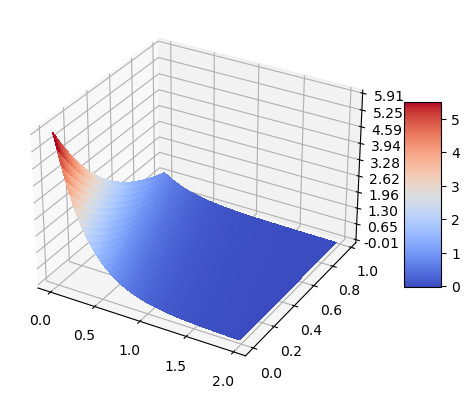

In [27]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter


fig = plt.figure()
#ax = fig.gca()
ax = plt.axes(projection='3d')

x = np.arange(0,2,0.02)
t = np.arange(0,1,.02)
xm, tm = np.meshgrid(x,t)

x = np.ravel(xm).reshape(-1,1)
t = np.ravel(tm).reshape(-1,1)

x_input = Variable(torch.from_numpy(x).float(), requires_grad=True).to(device)
t_input = Variable(torch.from_numpy(t).float(), requires_grad=True).to(device)

u_pred = model(x_input, t_input)
um = u_pred.data.cpu().numpy()
um = um.reshape(xm.shape)

surf = ax.plot_surface(xm, tm, um, cmap=cm.coolwarm, linewidth=0, antialiased=False)

ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

fig.colorbar(surf, shrink=.5, aspect=5)
plt.show()


In [33]:
def sol(x,t):
    return 6*np.exp(-3*x-2*t)
    
anal_sol = sol(x,t)
mse=np.mean((anal_sol-u_pred.data.cpu().numpy())**2)
print(f"Mean square error between analytical and ML solution: {mse}")

Mean square error between analytical and ML solution: 2.0228459377749487e-05
